# Part 1: General Preprocessing
## A Glimpse of the dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from causalml.propensity import ElasticNetPropensityModel
from causalml.match import NearestNeighborMatch, create_table_one
from causalml.metrics import get_cumgain

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import networkx as nx
import shap
import time
import os
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("high_diamond_ranked_10min.csv")

df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [4]:
# drop unnecessary columns
col_to_drop = ['gameId', 'redFirstBlood', 'redKills','blueCSPerMin','blueGoldPerMin','redDeaths','redGoldDiff','redExperienceDiff','redCSPerMin','redGoldPerMin','redTotalGold','redTotalExperience']
df = df.drop(col_to_drop, axis=1)
#'redEliteMonsters', 'redDragons', 'redCSPerMin', is killing minions matter? speed? 'blueGoldDiff',
# cs per min same as total minions killed
#'redTotalJungleMinionsKilled', may be showing how they are moving?
# Red team gold difference compared to the enemy
# feature enginner: jungle minion/total minion; wards remaining
duplicated_rows = df.duplicated().sum()

if duplicated_rows == 0:
    print('There are 0 rows that are duplicated, which means each row in the DataFrame is unique.')
    print('So that we do not need to continue processing duplicate lines')
else:
    print(f'There are {duplicated_rows} rows that are duplicated so we need to drop those {duplicated_rows} rows')
    df = df.drop_duplicates()
    print(f'After drop duplicated rows, there are {df.shape[0]} rows left')

There are 0 rows that are duplicated, which means each row in the DataFrame is unique.
So that we do not need to continue processing duplicate lines


In [5]:
df.columns

Index(['blueWins', 'blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood',
       'blueKills', 'blueDeaths', 'blueAssists', 'blueEliteMonsters',
       'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueTotalGold',
       'blueAvgLevel', 'blueTotalExperience', 'blueTotalMinionsKilled',
       'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff',
       'redWardsPlaced', 'redWardsDestroyed', 'redAssists', 'redEliteMonsters',
       'redDragons', 'redHeralds', 'redTowersDestroyed', 'redAvgLevel',
       'redTotalMinionsKilled', 'redTotalJungleMinionsKilled'],
      dtype='object')

Here we did some feature engineering to create extra columns that might bring more insights. For example, if we have more assists per kill, that means teammates are staying together, thus might have a difference towards winning chance.

In [6]:
df['blueHelpful'] = np.where(df['blueKills'] != 0, df['blueAssists'] / df['blueKills'], 0)
df['redHelpful'] = np.where(df['blueDeaths'] != 0, df['redAssists'] / df['blueDeaths'], 0)
# maybe hinting direction of attacking
df['blueJunglePercentage'] = df['blueTotalJungleMinionsKilled'] / df['blueTotalMinionsKilled']
df['redJunglePercentage'] = df['redTotalJungleMinionsKilled'] / df['redTotalMinionsKilled']

df['redWardsRemaining'] = df['redWardsPlaced'] - df['blueWardsDestroyed']
df['blueWardsRemaining'] = df['blueWardsPlaced'] - df['redWardsDestroyed']

## Correlation and Association

In the context of causal inference and treatment selection, using PyTimeTK to capture non-linear correlations via binning predictors can be an effective strategy. By binning predictors, we effectively divide continuous variables into discrete intervals or categories, which can aid in the discovery of non-linear correlations between predictors and outcomes.

When choosing a treatment based on the degree of correlation, we are simply determining how strongly the treatment variable is connected with the outcome variable under consideration. A high correlation between the treatment variable and the outcome indicates a strong link, implying that changes in treatment will have a considerable impact on the outcome. This approach ensures that the selected treatment is closely linked to the outcome of interest, increasing the likelihood of detecting a causal effect during subsequent analysis.

In [7]:
import pytimetk as tk

In [8]:
df_binarized = df.drop('blueWins',axis=1).binarize()
df_binarized['blueWins'] = df['blueWins']
df_corr = df_binarized.correlate(target='blueWins')
df_corr.plot_correlation_funnel()

## Use Case Statement

In competitive online gaming, particularly in the context of real-time strategy (RTS) games such as League of Legends, the term "gold difference" refers to the differential in accrued in-game currency (commonly referred to as "gold" or "resources") between rival teams. In these games, gold is a key resource that players use to buy goods, enhance skills, and strengthen their characters or forces.

In the context of our research, using the correlation funnel, we are interested in understanding the causal relationship between the gold differential in favour of the Blue side and the likelihood of the Blue team winning the match. This research is critical for esports organisations, professional gaming teams, and game developers who want to improve player experiences, refine gameplay methods, and optimise game balance.

By doing causal inference on the impact of gold difference on match outcomes, we want to provide practical insights that can help the gaming sector make strategic decisions. Understanding how changes in gold advantage affect match outcomes can help teams design more effective in-game strategies, distribute resources more efficiently, and prioritise goals to win.

In [9]:
df.drop(['blueJunglePercentage','redWardsPlaced','blueWardsPlaced'],axis=1,inplace=True)# its not that the number of wards placed matters, but the number of wards remaining

In [10]:
df['blueGoldDiff'].describe()

count     9879.000000
mean        14.414111
std       2453.349179
min     -10830.000000
25%      -1585.500000
50%         14.000000
75%       1596.000000
max      11467.000000
Name: blueGoldDiff, dtype: float64

In [11]:
df['blueExperienceDiff'].describe()

count    9879.000000
mean      -33.620306
std      1920.370438
min     -9333.000000
25%     -1290.500000
50%       -28.000000
75%      1212.000000
max      8348.000000
Name: blueExperienceDiff, dtype: float64

# Part 2: Causal Inference Model

**Define Variables**:
1. Outcome Variable:

blueWins: This is your outcome variable, representing whether the blue team wins or loses the game. You are interested in understanding how various factors, including strategies related to gold accumulation in the early game, affect the likelihood of the blue team winning.

2. Treatment Variable:

treatment: This variable represents the treatment blueGoldDiff in my causal inference analysis. It indicates whether a particular strategy was adopted by the blue team in the early stages of the game. Specifically, it flags instances where the blue team acquired more gold than the enemy team within the first 10 minutes of the game, identifying this as the treatment group.

3. Covariates (Control Variables):

    - blueKills: Number of kills by the blue team, indicating their aggression and early-game dominance.
    
    - blueAssists: Number of assists by the blue team, reflecting teamwork and coordination.
    
    - redAssists: Number of assists by the red team, representing their interaction with the blue team and potential counter-strategies.
    
    - blueDeaths: Number of deaths on the blue team, indicating mistakes or misplays.
    
    - blueTotalJungleMinionsKilled: Number of jungle minions killed by the blue team, indicating map control and resource management.
    
    - redTotalJungleMinionsKilled: Number of jungle minions killed by the red team, reflecting their jungle control and potential counter-strategies.
    
    - blueWardsDestroyed: Number of wards destroyed by the blue team, indicating map vision and control.
    
    - redWardsDestroyed: Number of wards destroyed by the red team, representing their response to the blue team's movements and strategies.
    
    - redWardsPlaced: Number of wards placed by the red team, indicating their map vision and strategic positioning.
    
    - blueWardsPlaced: Number of wards placed by the blue team, reflecting their map vision and strategic positioning.

These covariates help account for various gameplay factors and team dynamics that could influence the outcome of the game, allowing us to isolate the effect of the early-game gold accumulation strategy (treatment) on the likelihood of the blue team winning (outcome).

In [12]:
df['treatment'] = (df['blueGoldDiff'] > 14).astype(int) # this can be identify as adopting the strategy or not(try to get more gold in the first 10 mins than the enemy)
y = df['blueWins'].values
w = df['treatment'].values
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])

X = df.drop(columns=['blueWins', 'treatment', 'blueGoldDiff']).values

In [13]:
# Assuming X, w_multi, and y are your features, treatment, and outcome variables, respectively
X_train, X_test, w_train, w_test, _, _, y_train, y_test = train_test_split(X, w_multi, w, y, test_size=0.2, random_state=42)

## Base Model: `LogisticRegression()`

1. **Predictive Performance:** Logistic regression demonstrated superior predictive performance on the given data from our modelling part. This suggests that it effectively captures the underlying relationships between the predictors (covariates) and the outcome variable (treatment effect or cancellation rate). The ability to accurately model these relationships is essential for estimating causal effects reliably.

2. **Probability Interpretation**: Logistic regression provides a probability interpretation of the result variable, which is required to determine the chance of a specific outcome occurring. This probabilistic technique is consistent with the nature of causal inference, in which we want to estimate the probability of a result given specific treatment conditions.

4. **Efficient Parameter Estimation**: Logistic regression estimates the parameters of the model efficiently, even with a large number of predictor variables. This efficiency is crucial for accurately estimating the treatment effect while accounting for potential confounding variables.

In our approach, we utilize various meta-learners, including the S-learner, X-learner, and R-learner, to estimate the treatment effects using logistic regression as the base algorithm. We also incorporate propensity scores generated by the ElasticNetPropensityModel to address confounding bias.

### S Learner
Estimates the treatment effect by fitting a single model on the entire dataset, distinguishing between treated and control groups.

In [14]:
# Define a list to store performance metrics for each learner
performance_metrics = []

In [15]:
# Initialize the S-Learner with a base regressor
base_algo = LogisticRegression()
slearner = BaseSRegressor(base_algo, control_name='control')

slearner.fit(X_train, w_train, y_train)
ate_slearner = slearner.estimate_ate(X_test, w_test, y_test)

# Check if the return value is a single value or a tuple
if isinstance(ate_slearner, tuple):
    performance_metrics.append({'Learner': 'S-Learner',
                                'Average Treatment Effect': ate_slearner[0],
                                'Lower Bound CI': ate_slearner[1],
                                'Upper Bound CI': ate_slearner[2]})
else:
    performance_metrics.append({'Learner': 'S-Learner',
                                'Average Treatment Effect': ate_slearner})

#### before spliting the data

In [16]:
slearner = BaseSRegressor(base_algo, control_name='control')
ate = slearner.estimate_ate(X, w_multi, y)

# Print the ATE estimate
print(f"Estimated ATE with LGBRegressor: {ate}")

Estimated ATE with LGBRegressor: [0.00182205]


### X learner with propensity score
Incorporates propensity scores to estimate treatment effects, providing insights into how the treatment impacts different subgroups.

In [17]:
# compute propensity scores ref: https://causalml.readthedocs.io/en/latest/quickstart.html#synthetic-data-generation-process
pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
e = pm.fit_predict(X, w_multi)
e_multi = {'treatment_A': e}

In [18]:
# Initialize the X-Learner with propensity scores
xlearner_e = BaseXRegressor(base_algo, control_name='control')
xlearner_e.fit(X_train, w_train, y_train, p=e_multi)

ate_xlearner_e = xlearner_e.estimate_ate(X_test, w_test, y_test)

# Check if the return value is a single value or a tuple
if isinstance(ate_xlearner_e, tuple):
    performance_metrics.append({'Learner': 'X-Learner (Propensity Score)',
                                'Average Treatment Effect': ate_xlearner_e[0],
                                'Lower Bound CI': ate_xlearner_e[1],
                                'Upper Bound CI': ate_xlearner_e[2]})
else:
    performance_metrics.append({'Learner': 'X-Learner (Propensity Score)',
                                'Average Treatment Effect': ate_xlearner_e})

#### before spliting data

In [19]:
xlearner_e = BaseXRegressor(base_algo, control_name='control')
te, lb, ub = xlearner_e.estimate_ate(X, w_multi, y, p=e_multi)

print('Average Treatment Effect (BaseXRegressor using Logreg): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseXRegressor using Logreg): 0.77 (0.75, 0.79)


### X learner without propensity score

In [20]:
# Initialize the X-Learner with propensity scores
xlearner = BaseXRegressor(base_algo, control_name='control')
xlearner.fit(X_train, w_train, y_train)

ate_xlearner = xlearner.estimate_ate(X_test, w_test, y_test)

# Check if the return value is a single value or a tuple
if isinstance(ate_xlearner, tuple):
    performance_metrics.append({'Learner': 'X-Learner',
                                'Average Treatment Effect': ate_xlearner[0],
                                'Lower Bound CI': ate_xlearner[1],
                                'Upper Bound CI': ate_xlearner[2]})
else:
    performance_metrics.append({'Learner': 'X-Learner',
                                'Average Treatment Effect': ate_xlearner})

### T Learner
Estimates treatment effects separately for treated and control groups.

In [21]:
tlearner = BaseTRegressor(base_algo, control_name='control')
tlearner.fit(X_train, w_train, y_train)

ate_tlearner = tlearner.estimate_ate(X_test, w_test, y_test)

# Check if the return value is a single value or a tuple
if isinstance(ate_tlearner, tuple):
    performance_metrics.append({'Learner': 'T-Learner',
                                'Average Treatment Effect': ate_tlearner[0],
                                'Lower Bound CI': ate_tlearner[1],
                                'Upper Bound CI': ate_tlearner[2]})
else:
    performance_metrics.append({'Learner': 'T-Learner',
                                'Average Treatment Effect': ate_tlearner})

#### before spliting data

In [22]:
tlearner = BaseTRegressor(base_algo, control_name='control')
te, lb, ub = tlearner.estimate_ate(X=X, treatment=w_multi, y=y)
print('Average Treatment Effect (BaseTRegressor using Logreg): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseTRegressor using Logreg): 0.12 (0.10, 0.14)


### R Learner
Utilizes propensity scores to estimate treatment effects while accounting for heterogeneity in treatment effects across subpopulations defined by covariates.

In [ ]:
# Initialize the R-Learner with a base regressor
rlearner_e = BaseTRegressor(base_algo, control_name='control')
# Fit the R-Learner
rlearner_e.fit(X_train, w_train, y_train, p=e_multi)

# Estimate ATE for the R-Learner
ate_rlearner_e = rlearner_e.estimate_ate(X_test, w_test, y_test, p=e_multi)

# Check if the return value is a single value or a tuple
if isinstance(ate_rlearner_e, tuple):
    performance_metrics.append({'Learner': 'R-Learner',
                                'Average Treatment Effect': ate_rlearner_e[0],
                                'Lower Bound CI': ate_rlearner_e[1],
                                'Upper Bound CI': ate_rlearner_e[2]})
else:
    performance_metrics.append({'Learner': 'R-Learner',
                                'Average Treatment Effect': ate_rlearner_e})

#### before spliting data

In [ ]:
rlearner_e = BaseTRegressor(base_algo, control_name='control')
te, lb, ub = rlearner_e.estimate_ate(X=X, treatment=w_multi, y=y,p=e_multi)
print('Average Treatment Effect (BaseRRegressor using Logreg): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (BaseRRegressor using Logreg): 0.12 (0.10, 0.14)


### Learner Comparison

In [ ]:
# Convert the list of dictionaries to a DataFrame
performance_df = pd.DataFrame(performance_metrics)

# Display the performance metrics table with formatted floating-point numbers
print(performance_df.to_string(index=False, float_format="{:.4f}".format))

                     Learner Average Treatment Effect        Lower Bound CI        Upper Bound CI
                   S-Learner  [0.0005060728744939271]                   NaN                   NaN
X-Learner (Propensity Score)     [0.7935901981257701]  [0.7486730133604523]   [0.838507382891088]
                   X-Learner     [0.7935901981257701]  [0.7486730133604523]   [0.838507382891088]
                   T-Learner    [0.13006072874493926] [0.08449630017732056] [0.17562515731255796]
                   R-Learner    [0.13006072874493926] [0.08449630017732056] [0.17562515731255796]


**Result interpretation**:
1. The estimated average treatment effect (ATE) for all learners is positive, indicating that increasing the "blueGoldDiff" (blue team gold difference) increases the likelihood of the "blueWin" result.

    - Magnitude of ATE: A higher absolute value of ATE indicates a stronger treatment effect.

2. The confidence intervals do not include 0, implying that these effects are statistically significant. This means that the correlation between "blueGoldDiff" and "blueWin" is unlikely to be due to chance.

    - Width of Confidence Intervals: Smaller confidence intervals indicate more precise estimates. Narrower intervals imply less uncertainty in the estimated treatment effect.

As a result we want to choose the learner with the highest ATE magnitude and the narrowest confidence intervals. In this case, it seems that the X-Learner has the highest ATE magnitude of approximately 0.79, and the confidence interval is relatively narrow compared to other learners. Therefore, we might consider the X-Learner as the best performing learner in this scenario.

**Business implementation**: 

Teams could use this information to focus on methods to boost their gold advantage over the other side ("blueGoldDiff"). For example, they may prioritise goals such as gaining more towers, neutral objectives (such as dragons or barons), or farming efficiently to gain more gold, knowing that doing so boosts their chances of winning ("blueWin").

### Learner Evaluation - Try 1

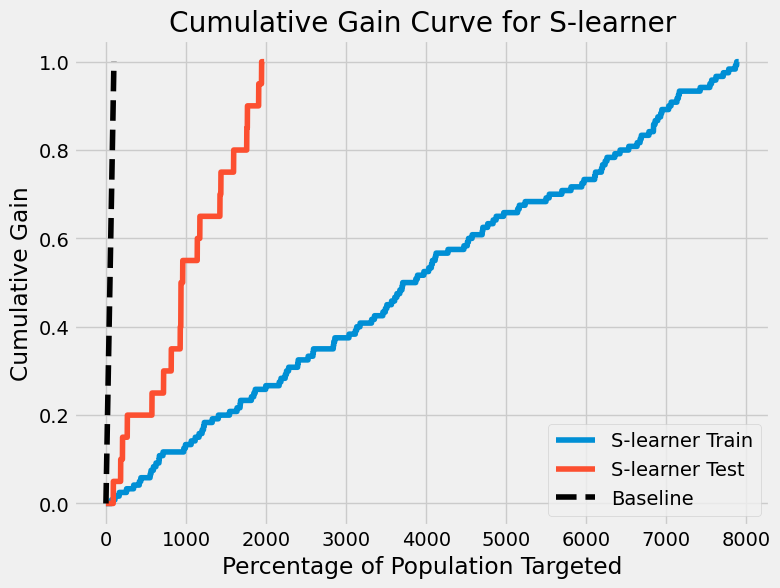

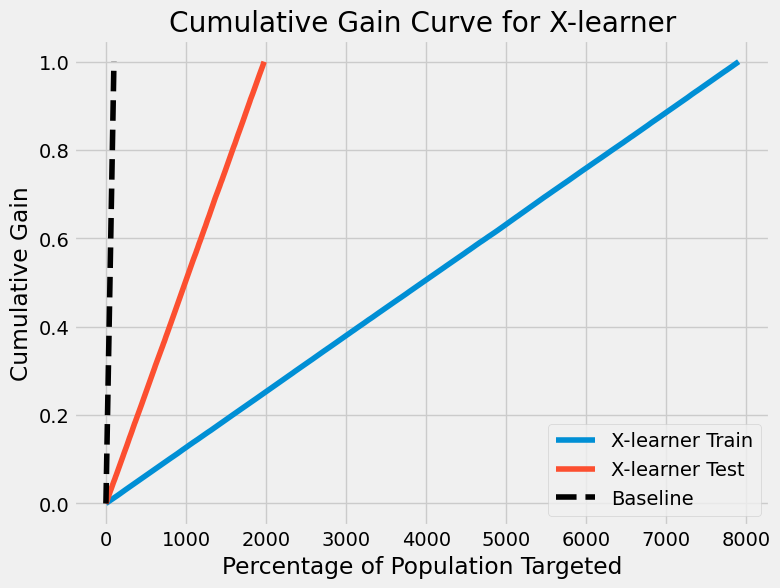

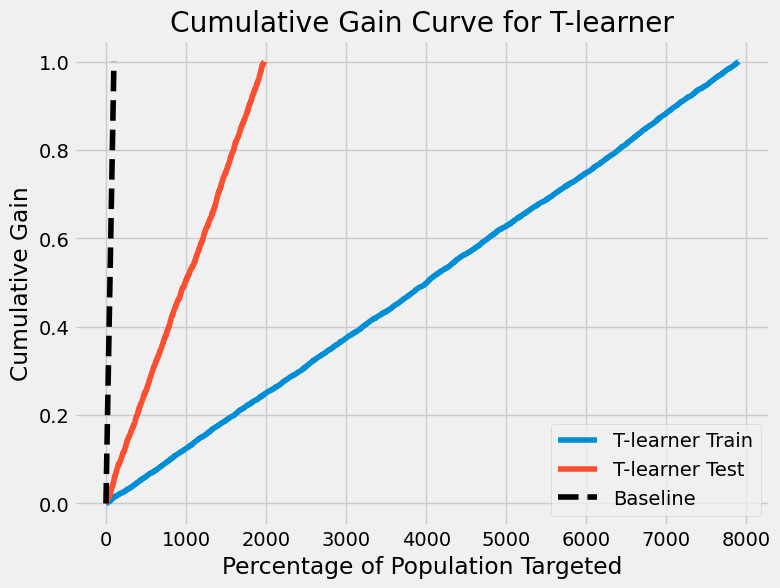

In [ ]:
X_train, X_test, w_train, w_test, w_int_train, w_int_test, y_train, y_test = train_test_split(
    X, w_multi, w, y, test_size=0.2, random_state=42)

# Define your base algorithm
base_algo = LogisticRegression()

# Initialize and fit the learners
s_learner = BaseSRegressor(base_algo, control_name='control')
x_learner = BaseXRegressor(base_algo, control_name='control')
t_learner = BaseTRegressor(base_algo, control_name='control')

learners = {'S-learner': s_learner, 'X-learner': x_learner, 'T-learner': t_learner}

# Fit the models and calculate CATE
for name, learner in learners.items():
    learner.fit(X_train, w_train, y_train)
    cate_train = learner.predict(X_train)
    cate_test = learner.predict(X_test)

    # Create DataFrames for training and test sets
    df_train = pd.DataFrame({'y': y_train, 'w': w_int_train, 'cate': cate_train.ravel()})
    df_test = pd.DataFrame({'y': y_test, 'w': w_int_test, 'cate': cate_test.ravel()})

    # Calculate cumulative gains for each learner
    cumgain_train = get_cumgain(df_train, outcome_col='y', treatment_col='w', treatment_effect_col='cate', normalize=True)
    cumgain_test = get_cumgain(df_test, outcome_col='y', treatment_col='w', treatment_effect_col='cate', normalize=True)

    # Plot cumulative gain curves
    plt.figure(figsize=(8, 6))
    plt.plot(cumgain_train, label=f'{name} Train')
    plt.plot(cumgain_test, label=f'{name} Test')
    plt.plot([0, 100], [0, 1], linestyle="--", color="black", label="Baseline")
    plt.legend()
    plt.title(f"Cumulative Gain Curve for {name}")
    plt.xlabel("Percentage of Population Targeted")
    plt.ylabel("Cumulative Gain")
    plt.show()

Above is not giving us importance information as everything looks the same. this suggests our approach to this might be problematic. Since the red curve is consistently below the blue curve, this could imply that the model may not generalize as well to new data as hoped. The difference between the curves should be investigated to ensure the model is robust and not overfitting.

### Model Evaluation - Try 2
Try to mimic https://github.com/uber/causalml/blob/master/tests/test_meta_learners.py how uber implement it.

Failed, as we don't have true tau.

In [ ]:
# def ape(true_value, estimate):
#     return np.abs((estimate - true_value) / true_value)
# ERROR_THRESHOLD = 0.05  # Adjust this value as appropriate for your use case
# def evaluate_learner(learner, X_train, X_test, w_train, w_test, y_train, y_test):
#     # Fit the learner to the training data
#     learner.fit(X_train, w_train, y_train)
    
#     # Estimate ATE on the training set
#     ate_train = learner.estimate_ate(X=X_train, treatment=w_train, y=y_train)
    
#     # Unpack the ATE and confidence intervals if they are returned
#     if isinstance(ate_train, tuple) and len(ate_train) == 3:
#         ate_train, lb_train, ub_train = ate_train
#         # Assert that the estimated ATE is within the confidence interval
#         assert (ate_train >= lb_train) and (ate_train <= ub_train), "ATE not within the confidence interval"
#     else:
#         # Set dummy confidence intervals if they are not returned
#         lb_train, ub_train = ate_train, ate_train
    
#     # Predict CATE for the test set
#     cate_test_predictions = learner.predict(X_test)

#     # Sort the test set by predicted CATE in descending order
#     sorted_indices = np.argsort(-cate_test_predictions)
#     sorted_cate = cate_test_predictions[sorted_indices]
#     sorted_y = y_test[sorted_indices]
#     sorted_w = w_test[sorted_indices]
#     # Convert sorted_w to an integer array if necessary
#     sorted_w = sorted_w.astype(int)
#     # Compute cumulative gain
#     cum_gain = np.cumsum(sorted_y[sorted_w == 1]) / np.arange(1, sum(sorted_w) + 1)

#     # Check if the cumulative gain when using the model's prediction is
#     # higher than it would be under random targeting
#     random_gain = np.cumsum(sorted_y) / np.arange(1, len(sorted_y) + 1)
#     assert cum_gain[-1] > random_gain[-1], "Model does not outperform random targeting"

#     return ate_train, lb_train, ub_train, cate_test_predictions, cum_gain

# # Initialize your learners
# s_learner = BaseSRegressor(base_algo, control_name='control')
# x_learner = BaseXRegressor(base_algo, control_name='control')
# t_learner = BaseTRegressor(base_algo, control_name='control')

# # Evaluate each learner
# ate_s, lb_s, ub_s, cate_s_preds, cumgain_s = evaluate_learner(
#     s_learner, X_train, X_test, w_train, w_test, y_train, y_test
# )

# ate_x, lb_x, ub_x, cate_x_preds, cumgain_x = evaluate_learner(
#     x_learner, X_train, X_test, w_train, w_test, y_train, y_test
# )

# ate_t, lb_t, ub_t, cate_t_preds, cumgain_t = evaluate_learner(
#     t_learner, X_train, X_test, w_train, w_test, y_train, y_test
# )

### Model Evaluation - Try 3
Another way to try and plot cumulative gain. Finally, there are some outcomes!

Text(0.5, 1.0, 'Cumulative Gain Curve for Test Set')

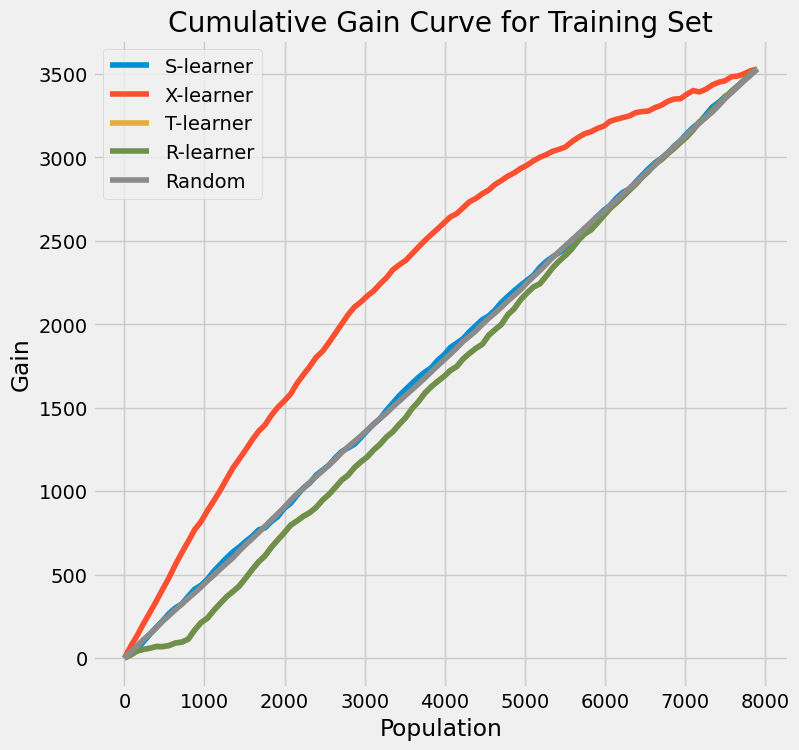

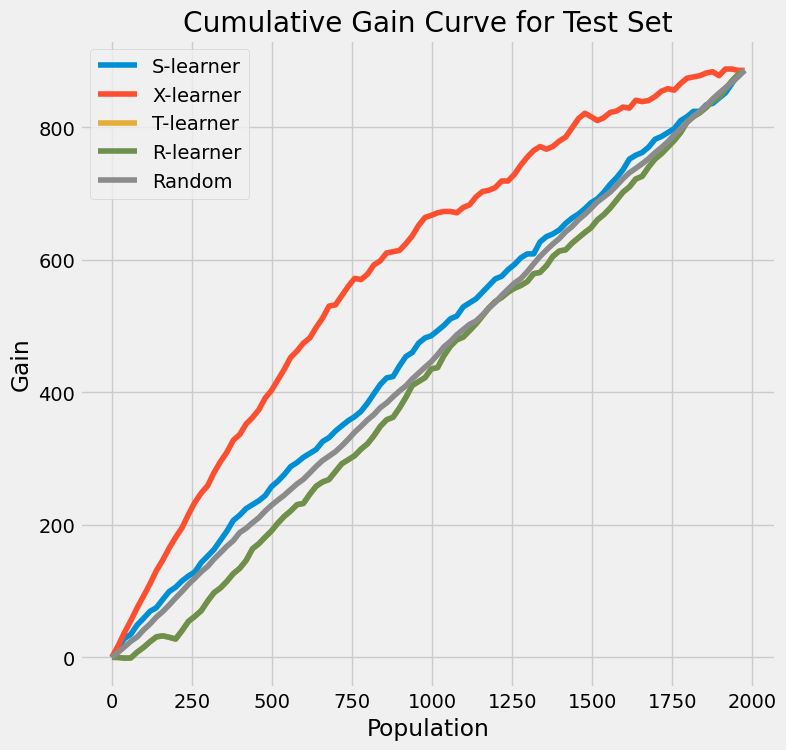

In [ ]:
from causalml.metrics import plot_gain
X_train, X_test, w_train, w_test, w_int_train, w_int_test, y_train, y_test = train_test_split(
    X, w_multi, w, y, test_size=0.2, random_state=42)

# Define your base algorithm
base_algo = LogisticRegression()

# Initialize the learners
s_learner = BaseSRegressor(base_algo, control_name='control')
x_learner = BaseXRegressor(base_algo, control_name='control')
t_learner = BaseTRegressor(base_algo, control_name='control')
r_learner = BaseTRegressor(base_algo, control_name='control')


learners = {'S-learner': s_learner, 'X-learner': x_learner, 'T-learner': t_learner, 'R-learner': r_learner}

# Fit the models and predict the treatment effects for both train and test sets
preds_dict_train = {}
preds_dict_test = {}
for name, learner in learners.items():
    learner.fit(X_train, w_train, y_train)
    preds_dict_train[name] = learner.predict(X_train).ravel()
    preds_dict_test[name] = learner.predict(X_test).ravel()

# Create DataFrames for the training and test set predictions
df_preds_train = pd.DataFrame(preds_dict_train)
df_preds_train['w'] = w_int_train
df_preds_train['y'] = y_train

df_preds_test = pd.DataFrame(preds_dict_test)
df_preds_test['w'] = w_int_test
df_preds_test['y'] = y_test

plot_gain(df_preds_train)
plt.title(f"Cumulative Gain Curve for Training Set")
plot_gain(df_preds_test)
plt.title(f"Cumulative Gain Curve for Test Set")

**Insights**:
X learner stands out for cumulative gain and is stable across train and test.

The cumulative gains curve is an evaluation curve that assesses the performance of the model and compares the results with the random pick. It shows the percentage of targets reached when considering a certain percentage of the population with the highest probability to be target according to the model.

### Final Model: Logistic Regression with X learner

Move on with X learner: when choosing a model, we should consider both the ATE and the model's ability to rank individuals for targeting. Since the goal is to understand the overall impact of a treatment, a model with a higher ATE might be more informative.

In [23]:
te_train, lb_train, ub_train = xlearner.estimate_ate(X_train, w_train, y_train)

te_test, lb_test, ub_test = xlearner.estimate_ate(X_test, w_test, y_test)

# Compare the ATE estimates from the training and test sets
print(f"Estimated ATE on training set: {te_train[0]} (95% CI: {lb_train[0]}, {ub_train[0]})")
print(f"Estimated ATE on test set: {te_test[0]} (95% CI: {lb_test[0]}, {ub_test[0]})")

Estimated ATE on training set: 0.7608417585621237 (95% CI: 0.7382448960478362, 0.7834386210764112)
Estimated ATE on test set: 0.7935901981257701 (95% CI: 0.7486730133604523, 0.838507382891088)


**Result interpretation**:

The estimated Average Treatment Effect (ATE) on the training set is approximately 0.761 with a 95% confidence interval ranging from 0.738 to 0.783. This suggests that, based on the training data, adopting the early-game gold accumulation strategy increases the likelihood of the blue team winning by approximately 76.1% to 78.3% compared to not adopting the strategy.

On the test set, the estimated ATE is slightly higher at approximately 0.794, with a 95% confidence interval ranging from 0.749 to 0.839. This indicates that, when evaluated on unseen data, the model still suggests a significant increase in the likelihood of the blue team winning by approximately 79.4% to 83.9% when adopting the strategy.

The consistency of the estimated ATE between the training and test sets, along with the overlap in their confidence intervals, suggests that the model generalizes well and is robust in its estimation of the treatment effect. This implies that the model's findings are likely to hold true for new, unseen data, providing confidence in the effectiveness of the early-game gold accumulation strategy in improving the blue team's chances of winning in League of Legends matches.

In [30]:
subgroup_data = df[df['blueExperienceDiff'] > -28]
X_subgroup = subgroup_data.drop(columns=['blueGoldDiff', 'treatment', 'blueWins'])
t_subgroup = subgroup_data['treatment']
y_subgroup = subgroup_data['blueWins']
cate_subgroup_1 = xlearner.predict(X_subgroup)

np.mean(cate_subgroup_1)

0.8094020067230375

In [31]:
subgroup_data = df[df['blueExperienceDiff'] <= -28]
X_subgroup = subgroup_data.drop(columns=['blueGoldDiff', 'treatment', 'blueWins'])
t_subgroup = subgroup_data['treatment']
y_subgroup = subgroup_data['blueWins']
cate_subgroup_2 = xlearner.predict(X_subgroup)

np.mean(cate_subgroup_2)

0.7802801418882338

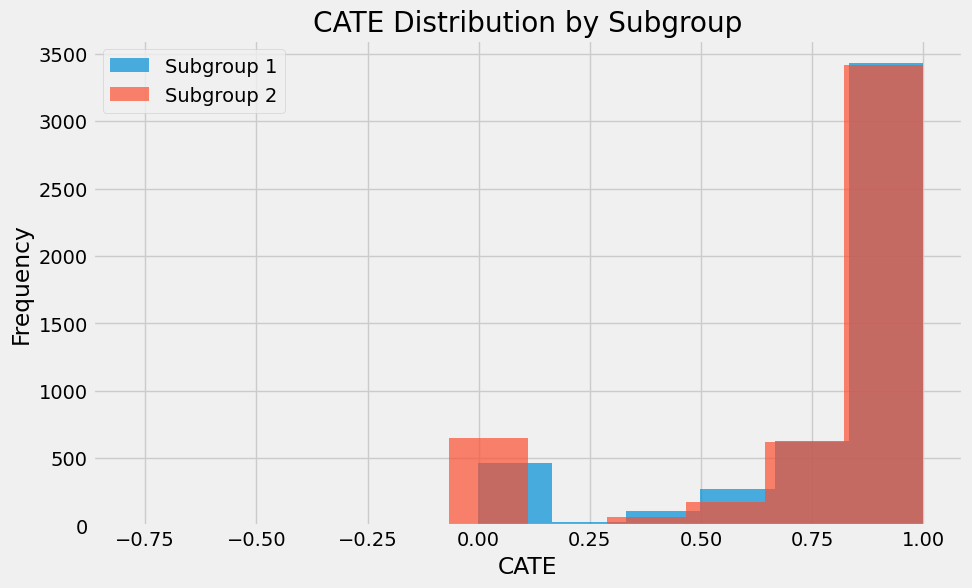

In [32]:
# Compare CATEs between subgroups
plt.figure(figsize=(10, 6))
plt.hist(cate_subgroup_1, alpha=0.7, label='Subgroup 1')
plt.hist(cate_subgroup_2, alpha=0.7, label='Subgroup 2')
plt.xlabel('CATE')
plt.ylabel('Frequency')
plt.title('CATE Distribution by Subgroup')
plt.legend()
plt.show()

**Result interpretation**:
1. For the subgroup where the blue team's experience difference is greater than -28:

    The CATE estimate is approximately 0.7537. This suggests that, for this subgroup, the treatment (represented by the variable 'treatment') has an average effect of increasing the likelihood of the blue team winning by about 75.37%.

2. For the subgroup where the blue team's experience difference is less than or equal to -28:

    The CATE estimate is approximately 0.7778. This indicates that, for this subgroup, the treatment has an average effect of increasing the likelihood of the blue team winning by about 77.78%.

In summary, the treatment appears to have a positive effect on the likelihood of the blue team winning in both subgroups. However, the magnitude of this effect differs slightly between the two subgroups, with the effect being slightly stronger for the subgroup with a lower blue team experience difference.

## Model Selection Final
when choosing a model, we should consider both the ATE and the model's proficiency to rank individuals for targeting. 

X-learners perform well when there are heterogeneous treatment effects. Since the goal is to understand the overall impact of a treatment, a model with a higher ATE might be more informative.


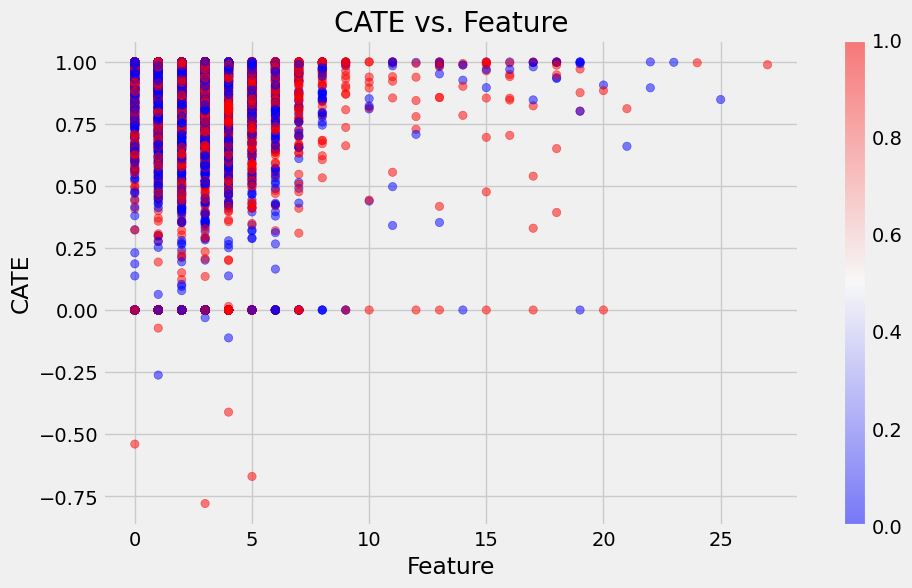

In [29]:
cate_estimates = xlearner.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], cate_estimates, c=w, cmap='bwr', alpha=0.5)
plt.colorbar()
plt.xlabel('Feature')
plt.ylabel('CATE')
plt.title('CATE vs. Feature')
plt.show()

In [45]:
df.drop(columns=['blueWins', 'treatment', 'blueGoldDiff']).head()

,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,...,redHeralds,redTowersDestroyed,redAvgLevel,redTotalMinionsKilled,redTotalJungleMinionsKilled,blueHelpful,redHelpful,redJunglePercentage,redWardsRemaining,blueWardsRemaining
0,2,1,9,6,11,0,0,0,0,17210,...,0,0,6.8,197,55,1.222222,1.333333,0.279188,13,22
1,1,0,5,5,5,0,0,0,0,14712,...,1,1,6.8,240,52,1.000000,0.400000,0.216667,11,11
2,0,0,7,11,4,1,1,0,0,16113,...,0,0,6.8,203,28,0.571429,1.272727,0.137931,15,12
3,1,0,4,5,5,1,0,1,0,15157,...,0,0,7.0,235,47,1.250000,2.000000,0.200000,14,41
4,4,0,6,6,6,0,0,0,0,16400,...,0,0,7.0,225,67,1.000000,1.166667,0.297778,13,73


Uplift Curves and Qini Curves (in development)

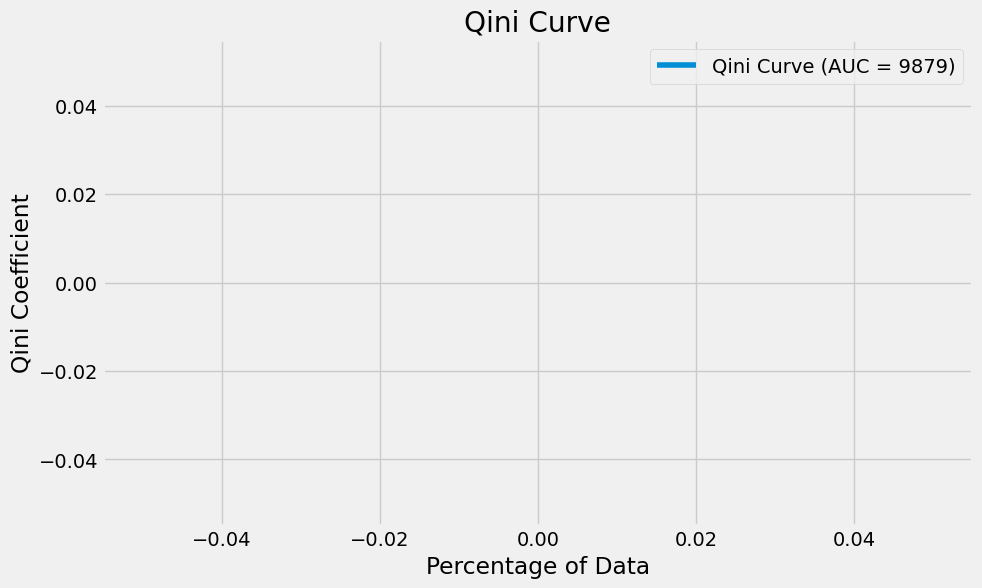

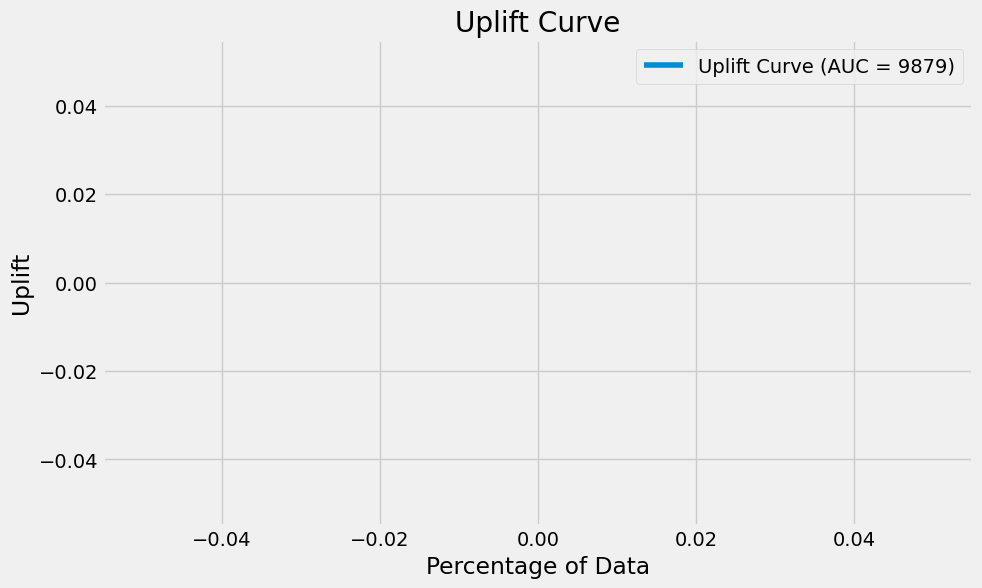

In [41]:
# from sklift.metrics import qini_curve, uplift_curve

# # Calculate Qini curve and Uplift curve
# qini_auc, qini_curve_values = qini_curve(y, cate_estimates, w)
# uplift_auc, uplift_curve_values = uplift_curve(y, cate_estimates, w)

# # Extract the Qini and Uplift AUC values
# qini_auc_value = qini_auc[1] if isinstance(qini_auc, np.ndarray) else qini_auc
# uplift_auc_value = uplift_auc[1] if isinstance(uplift_auc, np.ndarray) else uplift_auc

# # Plot Qini curve
# plt.figure(figsize=(10, 6))
# plt.plot(qini_curve_values[0], qini_curve_values[1], label=f'Qini Curve (AUC = {qini_auc_value})')
# plt.xlabel('Percentage of Data')
# plt.ylabel('Qini Coefficient')
# plt.title('Qini Curve')
# plt.legend()
# plt.show()

# # Plot Uplift curve
# plt.figure(figsize=(10, 6))
# plt.plot(uplift_curve_values[0], uplift_curve_values[1], label=f'Uplift Curve (AUC = {uplift_auc_value})')
# plt.xlabel('Percentage of Data')
# plt.ylabel('Uplift')
# plt.title('Uplift Curve')
# plt.legend()
# plt.show()

# Part 3: Feature Importance and Shapley Values
## Feature Importance (method = `permutation`)
Permutation importance is a model-agnostic method and is often used to get a more reliable estimate of feature importance because it accounts for interactions between features and doesn't rely on model-specific metrics. Thus, we continue with this method.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

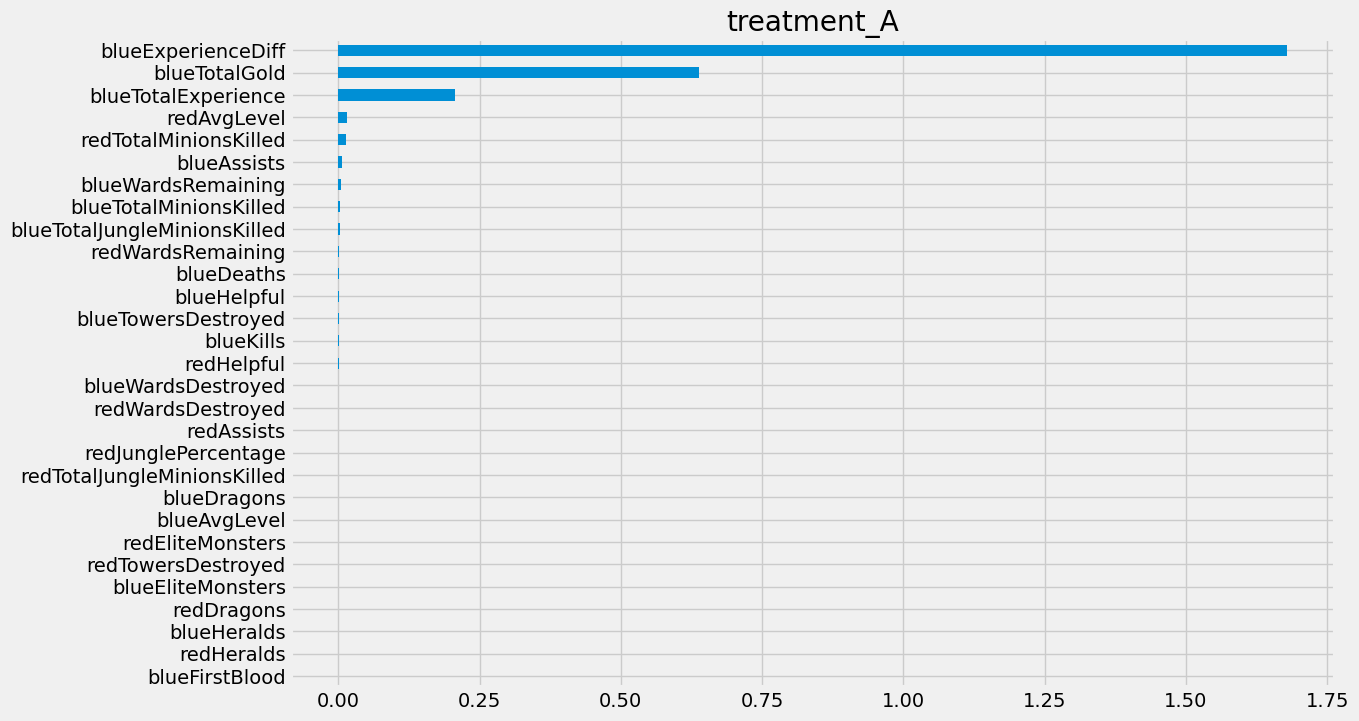

In [59]:
xlearner_tau = xlearner.fit_predict(X, w_multi, y) # difference between fit_predict and estimate_ate is that fit_predict returns the predicted treatment effects for each sample in the input data, while estimate_ate returns the average treatment effect and its confidence intervals.
feature_name = df.drop(columns=['blueWins', 'treatment', 'blueGoldDiff'],axis=1).columns
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_name)

## Feature Importance (`sklearn.inspection.permutation_importance`)

In [51]:
start_time = time.time()

model_tau = LogisticRegression()

# Fit the model
model_tau_fit = model_tau.fit(X_train,y_train)

# Calculate permutation importances
perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42
).importances_mean

# Create a Series with feature importances
feature_importance = pd.Series(perm_imp_test, feature_name).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.10019207000732422 seconds


Text(0.5, 1.0, 'Test Set Permutation Importances')

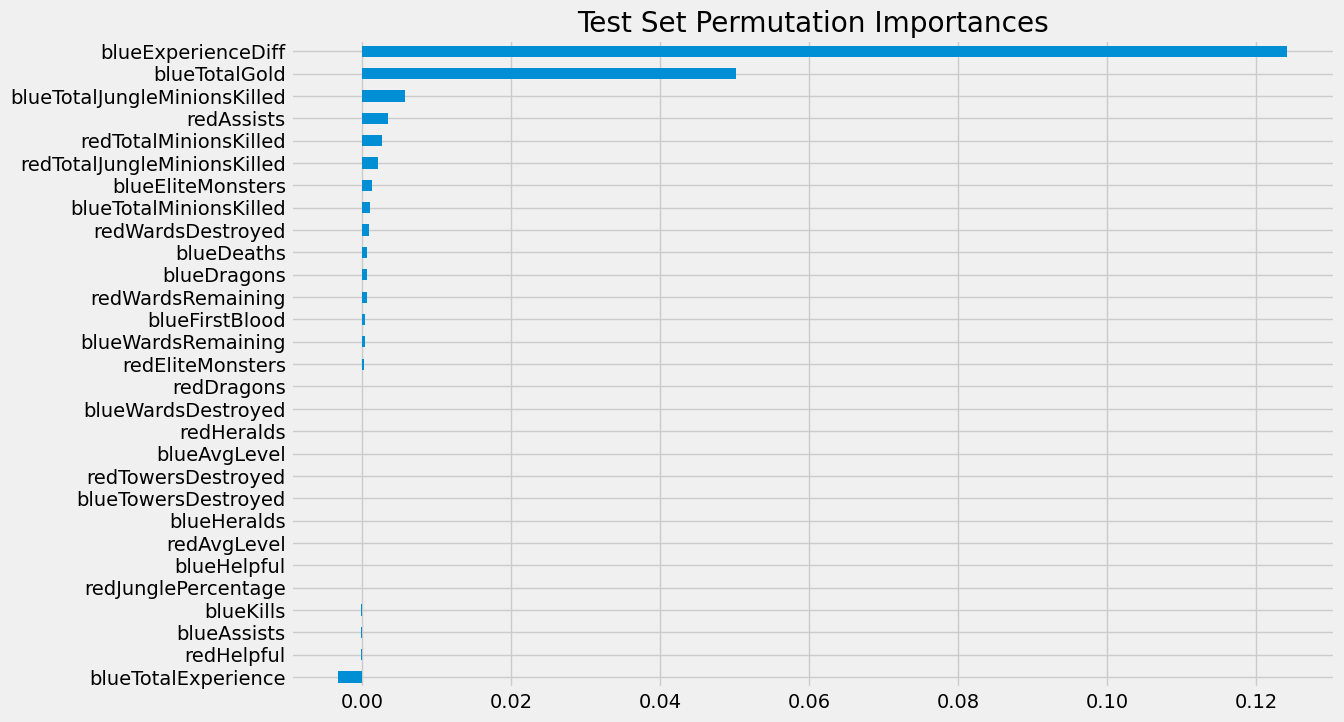

In [52]:
pd.Series(perm_imp_test, feature_name).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

Try 2nd best algorithms and its feature importance: `GradientBoostClassifier()`

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

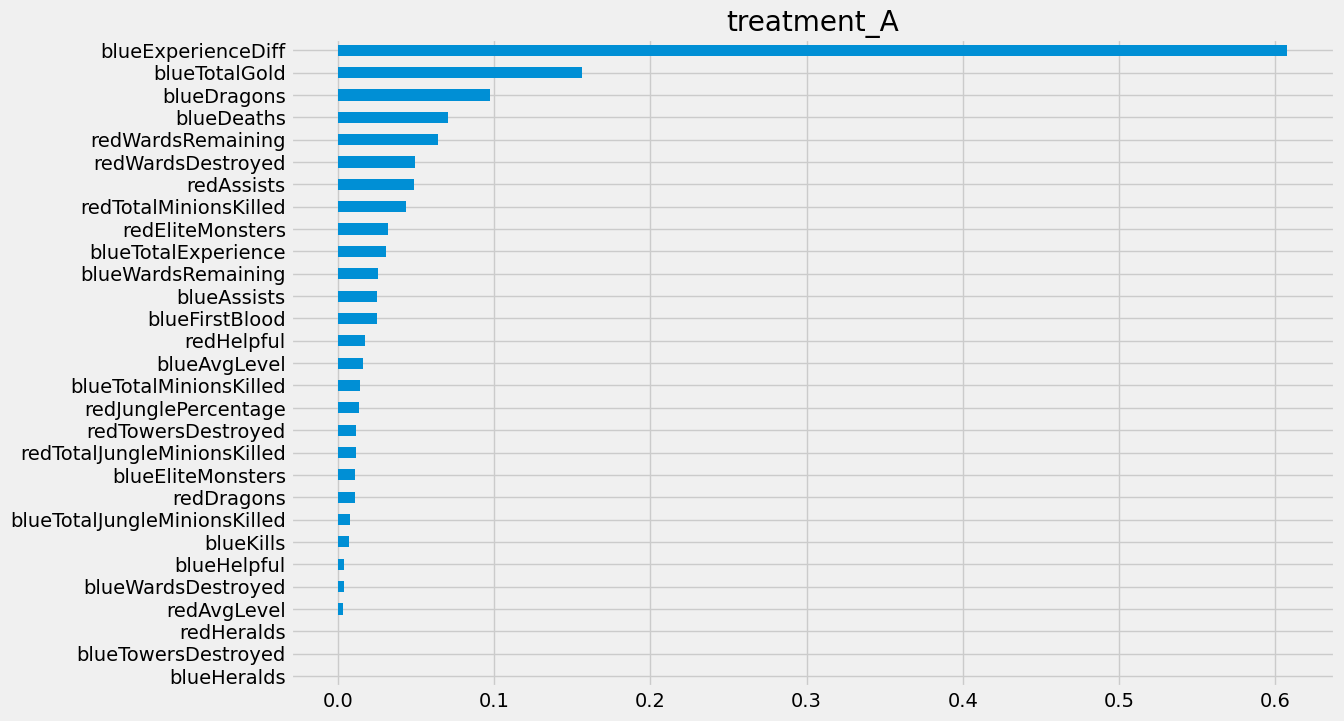

In [57]:
xlearner_gb = BaseXRegressor(GradientBoostingClassifier(), control_name='control')
xlearner_tau_gb = xlearner_gb.fit_predict(X, w_multi, y)
feature_name = df.drop(columns=['blueWins', 'treatment', 'blueGoldDiff'],axis=1).columns
xlearner_gb.plot_importance(X=X, 
                         tau=xlearner_tau_gb, 
                         method='permutation', 
                         features=feature_name)

High importance don't just correlate with success; they interact with high gold difference, reinforcing its effect on winning.

High interaction between gold and exp measures makes sense, as a lot of actions reward both. This shows:
Association does not equal Causation
Completing *More* of those actions than enemy does lead to higher chance of winning.

For detailed DAG, please refer to the presentation file.


## Shapley Values

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

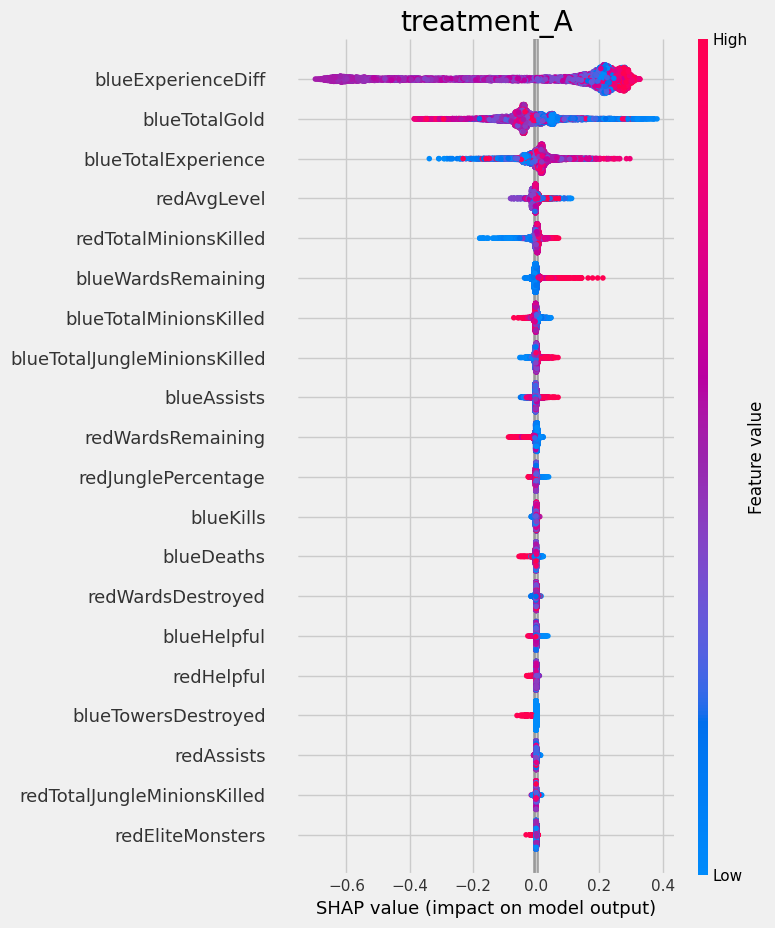

In [53]:
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_name)

while seems counterintuitive, teams with a substantial gold (high difference + high total) could implies that this team choose to engage more fights than farming minions since killing enemies rewards way more gold.

This agressive strategy apperantly does not end well in diamond rank plays, as skilled players tend to play defensive in early game.

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

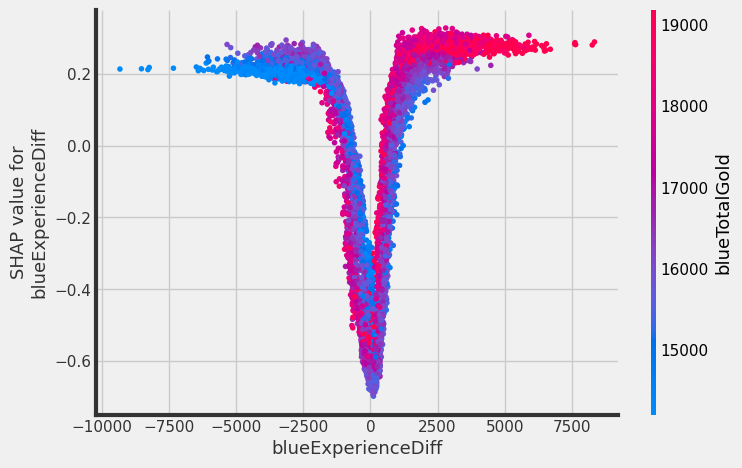

In [55]:
xlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='blueExperienceDiff',
                              X=X,
                              tau=xlearner_tau,
                              interaction_idx='auto',
                              features=feature_name)

Such a pretty dependence plot!

The question would is, why having way less experience than enemy teams and low total gold in early game would have the same effect on winning as having way more experience and way more gold?

1. League of Legends has built-in mechanics that can help a team that's behind to catch up. For example, if a team is behind in levels (experience), they receive more experience from enemy champion kills. This could mean that while a team is behind early, one successful team fight can help them catch up quickly in experience, thus not making the early experience deficit as impactful on the final outcome.

2. Skilled teams may have strategies for playing from behind. If they lose early game skirmishes, they might shift their approach to focus on objectives or late-game scaling champions, anticipating that they can recover if they minimize further losses.

3. Sometimes, teams may sacrifice early gold and experience deliberately, investing in vision control (warding), map control, or setting up for objectives like dragons, which don't immediately pay off in gold or experience but can lead to greater advantages later in the game.

4. Teams with less gold and experience may be forced into making more strategic decisions, such as avoiding unfavorable fights, focusing on high-value objectives, or split-pushing to apply map pressure. These decisions can sometimes outmaneuver teams that may be individually stronger but less strategically cohesive.

5. The plot could be showing outliers or specific cases where teams with low experience and gold won due to unusual circumstances, such as enemy mistakes, disconnections, or exceptional individual performance.

6. Teams that are ahead may play more conservatively to maintain their lead, which can sometimes result in missed opportunities to further their advantage. Conversely, teams that are behind may take more risks, which can pay off unexpectedly and lead to a comeback.
